In [27]:
#MSA
from Bio.Seq import Seq
import Bio.SeqIO as SeqIO
import random
import numpy as np

sick_patient_seq = SeqIO.read('HBS.fasta', 'fasta')
print(sick_patient_seq)
print(sick_patient_seq.seq)


# number of individuals in each generation 
NUM_SEQ = 10
POP_SIZE = 10
SEQ_LEN = 15
MOV_LEFT = -5
MOV_RIGHT = 5

ID: Sick
Name: Sick
Description: Sick patient HBB
Number of features: 0
Seq('ACATTTGCTTCTGACACAACTGTGTTCACTAGCAACCTCAAACAGACACCATGG...CAA', SingleLetterAlphabet())
ACATTTGCTTCTGACACAACTGTGTTCACTAGCAACCTCAAACAGACACCATGGTGCATCTGACTCCTGTGGAGAAGTCTGCCGTTACTGCCCTGTGGGGCAAGGTGAACGTGGATGAAGTTGGTGGTGAGGCCCTGGGCAGGCTGCTGGTGGTCTACCCTTGGACCCAGAGGTTCTTTGAGTCCTTTGGGGATCTGTCCACTCCTGATGCTGTTATGGGCAACCCTAAGGTGAAGGCTCATGGCAAGAAAGTGCTCGGTGCCTTTAGTGATGGCCTGGCTCACCTGGACAACCTCAAGGGCACCTTTGCCACACTGAGTGAGCTGCACTGTGACAAGCTGCACGTGGATCCTGAGAACTTCAGGCTCCTGGGCAACGTGCTGGTCTGTGTGCTGGCCCATCACTTTGGCAAAGAATTCACCCCACCAGTGCAGGCTGCCTATCAGAAAGTGGTGGCTGGTGTGGCTAATGCCCTGGCCCACAAGTATCACTAAGCTCGCTTTCTTGCTGTCCAATTTCTATTAAAGGTTCCTTTGTTCCCTAAGTCCAACTACTAAACTGGGGGATATTATGAAGGGCCTTGAGCATCTGGATTCTGCCTAATAAAAAACATTTATTTTCATTGCAA


In [28]:
def generate_sequence(base, length=5, prob=0.5):
    pattern = ""
    a = ["A","C","G","T"]
    
    for i in range(0, length):
        r = random.randrange(0,4)
        p = random.random()
        #print(r)
        if p >= prob:
            pattern += base[i]
        else:
            pattern += a[r]
            
    return pattern 

def generate_set(base):
    seq_set = []
    
    for i in range(0, NUM_SEQ):
        seq_set.append(generate_sequence(base, SEQ_LEN))
       
    return seq_set

base = 'ACATTTGCTTCTGACACAACTGTGTTCACTAGCAACCTCAAACAGACACCATGG'
sequences = generate_set(base)

In [29]:
sequences

['TCAAATGCTTCTGGC',
 'ATATCGAAGTCTCCC',
 'GCATGTGCTTCTGTT',
 'CAATTTGCCGCTGGC',
 'ACTTTTACTCTTGTA',
 'TCCTTCGTTGATTGC',
 'TCACTTTCTTGTAGA',
 'TCCTGCGCTTGCGAC',
 'ACGTTTGCTACCCCT',
 'TCGTGTCCTTTGGGC']

In [30]:
#Creation of initial population(movement of each sequence is a number between MOV_LEFT and MOV_RIGHT)
def initial_population(sequences, population_size):
    population = []
    movements = [i for i in range(MOV_LEFT, MOV_RIGHT)]
    
    for _ in range(population_size):
        population.append(random.sample(movements, len(sequences)))
        
    return population

initial_pop = initial_population(sequences, POP_SIZE)

In [31]:
initial_pop

[[-2, 1, 4, 0, 3, -5, 2, -3, -4, -1],
 [1, 3, -4, 2, -1, -3, -5, 0, -2, 4],
 [-3, -1, -4, 3, -5, 1, 4, -2, 2, 0],
 [3, -4, -3, 0, 1, 2, 4, -5, -1, -2],
 [-2, 1, 3, -4, 4, -5, -1, -3, 0, 2],
 [4, -1, -2, 0, -5, 2, 3, -4, 1, -3],
 [-5, 0, 4, 1, -4, -3, -2, 2, -1, 3],
 [-5, 1, 0, 3, -2, -1, -3, -4, 2, 4],
 [-4, -3, 4, -5, 1, -2, -1, 0, 3, 2],
 [-5, -3, -4, 4, 0, 1, 3, 2, -2, -1]]

In [40]:
def calc_score(seqs):
    s = np.array(seqs)
    
    score = 0
    
    #looking for num of cols
    for i in range(0,s.shape[1]):
        #print(len(set(s[:,i])))
        score += len(set(s[:,i]))
        
    return score

def MSA(ps, top=5):
    scores = []
    top_scores = []
    if top > NUM_SEQ:
        print("Top must be smaller or the same num as number of sequences.")
        return
    for i in range(0, len(ps)):
        scores.append((initial_pop[i],calc_score(ps[i])))
    scores = sorted(scores, key=lambda x: x[1])
    
    for i in range(0, top):
        top_scores.append(scores[i])

    return top_scores 

def pad_sequence(seq, pad, l ,r):
    sample_size = r - l + SEQ_LEN + 1
    sample = ['-' for i in range(sample_size)]
    
    sample[pad - l: pad - l + len(seq)] = seq

    return sample


def padded_sequences(initial_pop):
    #padded based on population
    padded_sequences = []
    for i in range(0,len(initial_pop)):
        #highest and lowest padding values
        l = min(initial_pop[i])
        r = max(initial_pop[i])
        #for each chromosome
        padded_seqs = []
        for p,s in zip(initial_pop[i], sequences):
            padded_seqs.append(pad_sequence(s, p, l, r))
        padded_sequences.append(padded_seqs)
    return padded_sequences


[([1, 3, -4, 2, -1, -3, -5, 0, -2, 4], 85), ([-5, 1, 0, 3, -2, -1, -3, -4, 2, 4], 86), ([-3, -1, -4, 3, -5, 1, 4, -2, 2, 0], 87), ([-5, 0, 4, 1, -4, -3, -2, 2, -1, 3], 89), ([-5, -3, -4, 4, 0, 1, 3, 2, -2, -1], 89)]


In [66]:
def mutate(chromosome, mutated = 1, p = 0.1):
    mut = random.random()
    new_chr = chromosome
    if(mut < p):
        for j in range(0, mutated):
            #picking random character position to be mutated
            pos = random.randrange(0, len(new_chr))
            r = random.randrange(MOV_LEFT,MOV_RIGHT)
            new_chr[pos] = r
    return new_chr

def crossover_and_generate_new(top_chromosomes):
    global POP_SIZE
    new_pop = []
    #generating new population
    for i in range(0,round(POP_SIZE/2)):
        r = random.randrange(0, NUM_SEQ-1)
        r_ch1 = random.randrange(0, len(top_chromosomes))
        r_ch2 = random.randrange(0, len(top_chromosomes))
        
        #crossover
        new_chr = top_chromosomes[r_ch1][0][:r] + top_chromosomes[r_ch2][0][r:]
        new_chr2 = top_chromosomes[r_ch1][0][r:] + top_chromosomes[r_ch2][0][:r]
        
        #performing mutation if mut is bigger than p
        new_chr = mutate(new_chr)
        new_chr2 = mutate(new_chr2)
        
        new_pop.append(new_chr)
        new_pop.append(new_chr2)
        
    return new_pop

#initial pop 

padded_seqs = padded_sequences(initial_pop)
    
top_chromosomes = MSA(padded_seqs)
print(top_chromosomes)

#iterations until some convergence
num_iter = 100
conv = []
for i in range(0, num_iter):
    #print(top_chromosomes)
    new_population = crossover_and_generate_new(top_chromosomes)
    #print(new_population)
    padded_seqs2 = padded_sequences(new_population)
    top_chromosomes2 = MSA(padded_seqs2)
    #print(top_chromosomes2)
    conv.append(top_chromosomes2)
    

[([1, 3, -4, 2, -1, -3, -5, 0, -2, 4], 85), ([-5, 1, 0, 3, -2, -1, -3, -4, 2, 4], 86), ([-3, -1, -4, 3, -5, 1, 4, -2, 2, 0], 87), ([-5, 0, 4, 1, -4, -3, -2, 2, -1, 3], 89), ([-5, -3, -4, 4, 0, 1, 3, 2, -2, -1], 89)]
[([-3, -1, -4, 3, -5, 1, 4, -2, 2, 0], 79), ([1, 3, -4, 2, -1, -3, -5, 0, -2, 4], 82), ([-2, 1, 3, -4, 4, -5, -1, -3, 0, 2], 82), ([-2, 1, 4, 0, 3, -5, 2, -3, -4, -1], 84), ([-5, -3, -4, 4, 0, 1, 3, 2, -2, -1], 86)]
[([-2, 1, 4, 0, 3, -5, 2, -3, -4, -1], 81), ([-3, -1, -4, 3, -5, 1, 4, -2, 2, 0], 84), ([-4, -3, 4, -5, 1, -2, -1, 0, 3, 2], 85), ([-2, 1, 3, -4, 4, -5, -1, -3, 0, 2], 86), ([-5, 0, 4, 1, -4, -3, -2, 2, -1, 3], 89)]
[([3, -4, -3, 0, 1, 2, 4, -5, -1, -2], 82), ([-4, -3, 4, -5, 1, -2, -1, 0, 3, 2], 82), ([-2, 1, 4, 0, 3, -5, 2, -3, -4, -1], 83), ([-5, -3, -4, 4, 0, 1, 3, 2, -2, -1], 85), ([-5, 0, 4, 1, -4, -3, -2, 2, -1, 3], 87)]
[([3, -4, -3, 0, 1, 2, 4, -5, -1, -2], 82), ([-3, -1, -4, 3, -5, 1, 4, -2, 2, 0], 84), ([-5, 0, 4, 1, -4, -3, -2, 2, -1, 3], 84), ([4, -

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

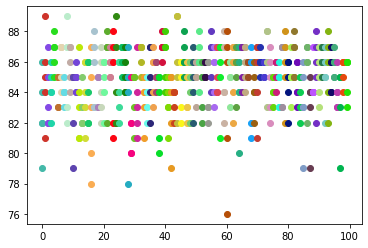

In [67]:
import matplotlib.pyplot as plt

for i in range(0, len(conv)):
    c = np.random.rand(3,)
    for j in range(0, 5):
       # print(conv[i][j][1])
        plt.scatter(i, conv[i][j][1], c=c)
plt.show()